In [35]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch

from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood


In [89]:
device= torch.device("cpu")
dim=1
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),)).squeeze()
    return torch.where(torch.logical_and(x > 0.5, x < 1.5),
                       (4 * np.pi * x).sin(),
                       (2 * np.pi * x).sin()).squeeze() + noise * m


In [90]:
def generate_data(n=1024, nood=32):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        ood_x = torch.zeros(32, 1).uniform_(0.5, 1.5) # it's not really ood x, but just the x s that are in the spiked regions
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(nood // 4, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(nood // 4, 1).uniform_(2, 2.25)), 0)
        ood_x = torch.cat((ood_x, torch.zeros(nood, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, x_test, y_test_true, ood_x, ood_y

x, y, x_test, y_test, ood_x, ood_y = generate_data(100, 24)

ood_y = oracle(ood_x)
X_train = x.squeeze()
Y_train = y.squeeze()
x_test = x_test.squeeze()
y_test = y_test.squeeze()
ood_x = ood_x.squeeze()


def cheat_remove(xx, interval):
    ## xx is a 2 x 1 tensor
    return ood_x[torch.logical_or(ood_x > interval[1], ood_x < interval[0])]
    

ood_x = cheat_remove(ood_x, (0.68, 0.7))
ood_y = oracle(ood_x)



In [109]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel() + gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [110]:
model = ExactGPModel(X_train, Y_train, GaussianLikelihood()).to(device)
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., requires_grad=True)),
 ('covar_module.base_kernel.kernels.0.raw_period_length',
  Parameter containing:
  tensor([[0.]], requires_grad=True)),
 ('covar_module.base_kernel.kernels.1.raw_lengthscale',
  Parameter containing:
  tensor([[0.]], requires_grad=True))]

In [115]:
model.covar_module.base_kernel.kernels[0]

CosineKernel(
  (raw_period_length_constraint): Positive()
)

In [126]:
def train_gp(X_train, Y_train, training_iter=100, lr=0.1):

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(X_train, Y_train, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X_train)
        # Calc loss and backprop gradients
        loss = -mll(output, Y_train)
        loss.backward()
        if i % 10 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: ?   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                # model.covar_module.base_kernel.period_length.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_test))

    return observed_pred, model, likelihood

In [120]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., requires_grad=True)),
 ('covar_module.base_kernel.kernels.0.raw_period_length',
  Parameter containing:
  tensor([[0.]], requires_grad=True)),
 ('covar_module.base_kernel.kernels.1.raw_lengthscale',
  Parameter containing:
  tensor([[0.]], requires_grad=True))]

Iter 1/100 - Loss: 0.874   lengthscale: ?   noise: 0.693
Iter 11/100 - Loss: 0.432   lengthscale: ?   noise: 0.311
Iter 21/100 - Loss: -0.011   lengthscale: ?   noise: 0.122
Iter 31/100 - Loss: -0.492   lengthscale: ?   noise: 0.044
Iter 41/100 - Loss: -0.994   lengthscale: ?   noise: 0.016
Iter 51/100 - Loss: -1.482   lengthscale: ?   noise: 0.005
Iter 61/100 - Loss: -1.984   lengthscale: ?   noise: 0.002
Iter 71/100 - Loss: -2.430   lengthscale: ?   noise: 0.001
Iter 81/100 - Loss: -2.778   lengthscale: ?   noise: 0.000
Iter 91/100 - Loss: -2.914   lengthscale: ?   noise: 0.000


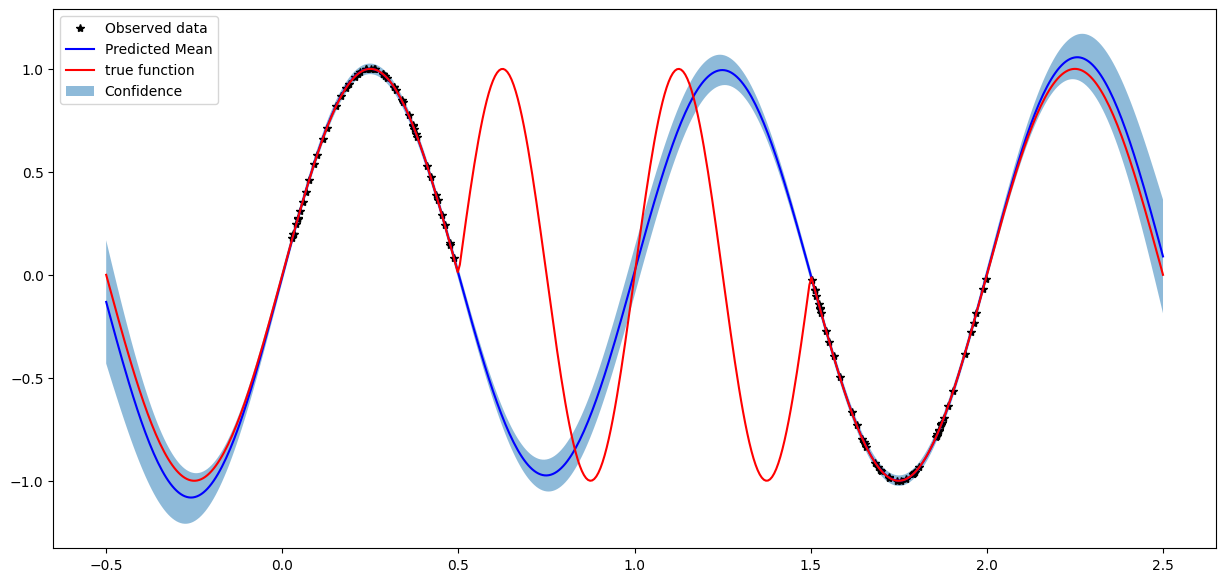

In [127]:
observed_pred, model, likelihood = train_gp(X_train, Y_train)
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 7))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train.numpy(), Y_train.numpy(), 'k*', label='Observed data')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'b', label='Predicted Mean')
    ax.plot(x_test.numpy(), y_test.numpy(), 'r', label='true function')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
    ax.legend()

Iter 1/5000 - Loss: 0.879   lengthscale: ?   noise: 0.693
Iter 11/5000 - Loss: 0.845   lengthscale: ?   noise: 0.644
Iter 21/5000 - Loss: 0.805   lengthscale: ?   noise: 0.598
Iter 31/5000 - Loss: 0.751   lengthscale: ?   noise: 0.554
Iter 41/5000 - Loss: 0.705   lengthscale: ?   noise: 0.511
Iter 51/5000 - Loss: 0.665   lengthscale: ?   noise: 0.470
Iter 61/5000 - Loss: 0.624   lengthscale: ?   noise: 0.432
Iter 71/5000 - Loss: 0.583   lengthscale: ?   noise: 0.396
Iter 81/5000 - Loss: 0.542   lengthscale: ?   noise: 0.363
Iter 91/5000 - Loss: 0.501   lengthscale: ?   noise: 0.332
Iter 101/5000 - Loss: 0.461   lengthscale: ?   noise: 0.303
Iter 111/5000 - Loss: 0.421   lengthscale: ?   noise: 0.276
Iter 121/5000 - Loss: 0.382   lengthscale: ?   noise: 0.252
Iter 131/5000 - Loss: 0.343   lengthscale: ?   noise: 0.230
Iter 141/5000 - Loss: 0.304   lengthscale: ?   noise: 0.209
Iter 151/5000 - Loss: 0.267   lengthscale: ?   noise: 0.190
Iter 161/5000 - Loss: 0.230   lengthscale: ?   nois

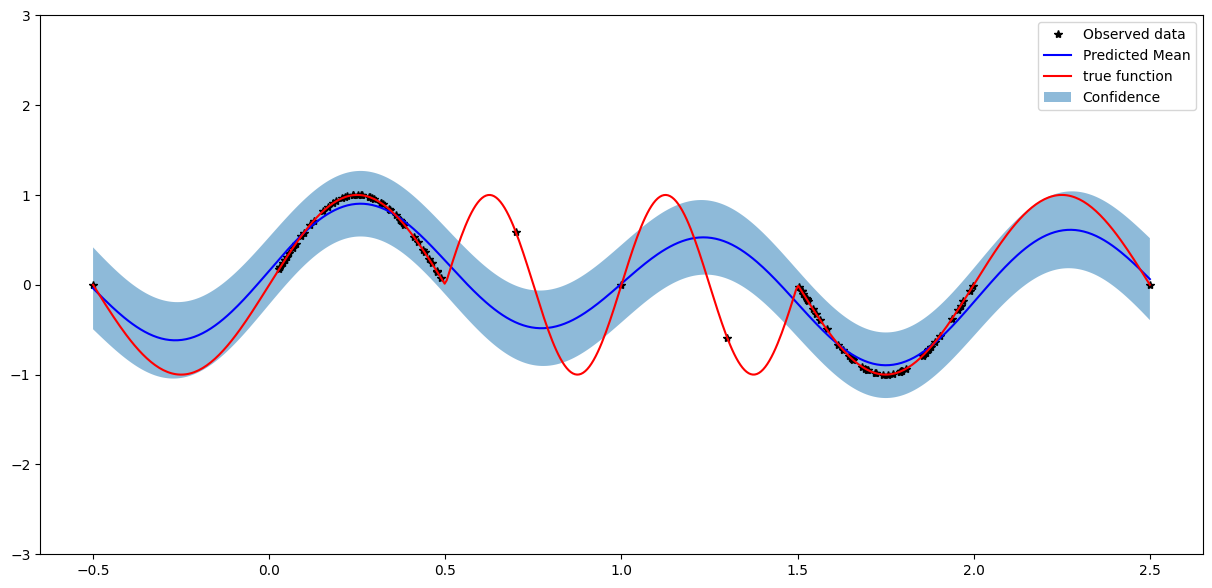

In [129]:

ood_x = torch.FloatTensor([[0.7], [1.0], [-0.5], [2.5], [1.3]]).squeeze()
ood_y = oracle(ood_x)


X = torch.cat([X_train, ood_x])
Y = torch.cat([Y_train, ood_y])

observed_pred, model, likelihood = train_gp(X, Y, training_iter=5000, lr=0.01)
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 7))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X.numpy(), Y.numpy(), 'k*', label='Observed data')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'b', label='Predicted Mean')
    ax.plot(x_test.numpy(), y_test.numpy(), 'r', label='true function')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
    ax.set_ylim([-3, 3])
    ax.legend()

In [50]:
Y_train

tensor([ 0.4389,  0.1640,  0.9773,  0.9678,  0.1102,  0.3720,  0.7031,  0.3607,
         0.9999,  0.4386,  0.5122,  0.0910,  0.8657,  0.4144,  0.7858,  0.7903,
         0.2098,  0.2550,  0.7175,  0.3821,  0.9801,  0.9974,  0.5795,  0.9853,
         0.3556,  0.9358,  0.3446,  0.9193,  0.6621,  0.9411,  0.9777,  0.9281,
         0.4432,  0.9293,  0.2698,  0.9880,  0.9889,  0.8490,  0.8092,  0.9593,
         0.8355,  0.6620,  0.4110,  0.4931,  0.6698,  0.4406,  0.8824,  0.2829,
         0.2714,  0.9945, -0.6336, -0.9851, -0.9665, -0.9993, -0.6951, -0.7473,
        -0.7277, -0.3478, -0.9278, -0.7971, -0.4193, -0.8546, -0.8394, -0.8268,
        -0.5991, -0.6671, -0.9978, -0.4150, -0.3347, -0.7402, -0.1974, -0.0268,
        -0.0802, -0.7254, -0.8218, -0.2256, -0.9365, -0.8919, -0.9602, -0.6421,
        -0.1077, -0.2745, -0.6171, -0.8830, -0.7157, -0.9955, -0.9449, -0.2355,
        -0.7091, -0.9449, -0.4865, -0.9900, -0.9399, -0.9751, -0.9849, -0.9980,
        -0.1976, -0.9967, -0.8033, -0.29